In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install ultralytics


import ultralytics
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os


fatal: destination path 'yolov5' already exists and is not an empty directory.
/kaggle/working/yolov5
Note: you may need to restart the kernel to use updated packages.
/kaggle/working


In [4]:
data_yaml_path = '/kaggle/input/radroad-anomaly-detection/images/data.yaml'
epochs_list = [40, 35, 25]
imgsz_list = [640, 960, 1280]
batch_size = 8
save_period = 5
source_images = '/kaggle/input/radroad-anomaly-detection/images/test/images'
video_path = '/kaggle/input/radroad-anomaly-detection/videos_without_audio/10th July-20231125T045234Z-001/10th July/111_10-07-2023.mp4'


In [5]:
def train_yolov8(model_path, data_yaml_path, epochs_list, imgsz_list, batch_size, save_period, run_name_prefix):
 
    model = YOLO(model_path)
    for i, (epochs, imgsz) in enumerate(zip(epochs_list, imgsz_list)):
        run_name = f"{run_name_prefix}_stage{i+1}"
        model.train(data=data_yaml_path, epochs=epochs, imgsz=imgsz, batch=batch_size, save_period=save_period, name=run_name)


def display_image(image_path, title):
    if os.path.exists(image_path):
        display(Image(filename=image_path, width=600))
        print(title)
        print()
    else:
        print(f"Image not found: {image_path}")

def validate_yolov8(model_paths, data_yaml_path):
    for model_path in model_paths:
        !yolo task=detect mode=val model={model_path} data={data_yaml_path}
        print()
def predict_yolov8(model_paths, source_images):
    for model_path in model_paths:
        !yolo task=detect mode=predict model={model_path} conf=0.25 source={source_images}
        print()


def inference_video_yolov8(model_path, video_path, output_path):
    model = YOLO(model_path)

    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    if not cap.isOpened():
        print("Error: Could not open video file")
    else:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            results = model(frame) 
            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].tolist()
                    conf = box.conf[0] 
                    cls = int(box.cls[0]) 
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
                    label = f'{model.names[cls]} {conf:.2f}'
                    cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            out.write(frame)

        cap.release()
        out.release()
        print(f"YOLOv8 Output video saved as '{output_path}'")

def inference_video_yolov5(model_path, video_path, output_path):
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, source='local')

    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    if not cap.isOpened():
        print("Error: Could not open video file")
    else:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            results = model(frame)
            detections = results.pandas().xyxy[0]
            for _, row in detections.iterrows():
                x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
                conf = row['confidence']
                cls = int(row['class'])
                label = f"{model.names[cls]} {conf:.2f}"
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            out.write(frame)

        cap.release()
        out.release()
        print(f"YOLOv5 Output video saved as '{output_path}'")


In [6]:
model_path_yolov8 = 'yolov8n.pt'  
run_name_prefix_yolov8 = 'yolov8'
train_yolov8(model_path_yolov8, data_yaml_path, epochs_list, imgsz_list, batch_size, save_period, run_name_prefix_yolov8)

Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/radroad-anomaly-detection/images/data.yaml, epochs=40, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=yolov8_stage12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

2024-10-27 17:47:05,097	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-27 17:47:05,721	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 53.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/radroad-anomaly-detection/images/train/labels... 5843 images, 64 backgrounds, 0 corrupt: 100%|██████████| 5843/5843 [00:21<00:00, 278.22it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/radroad-anomaly-detection/images/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/radroad-anomaly-detection/images/valid/labels... 1288 images, 14 backgrounds, 0 corrupt: 100%|██████████| 1288/1288 [00:04<00:00, 275.33it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/radroad-anomaly-detection/images/valid is not writeable, cache not saved.
Plotting labels to runs/detect/yolov8_stage12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8_stage12
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      1.27G      1.763      2.102       1.31         27        640: 100%|██████████| 731/731 [01:40<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.31it/s]


                   all       1288       4559      0.718       0.39      0.432       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      1.25G      1.739       1.62      1.324         18        640: 100%|██████████| 731/731 [01:36<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.19it/s]


                   all       1288       4559      0.529      0.436      0.444      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      1.23G      1.721      1.477      1.322         12        640: 100%|██████████| 731/731 [01:35<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.62it/s]


                   all       1288       4559      0.466      0.486      0.453      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      1.24G      1.697      1.399      1.313         11        640: 100%|██████████| 731/731 [01:34<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.51it/s]


                   all       1288       4559      0.491      0.507      0.481      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      1.24G       1.67      1.331      1.303         18        640: 100%|██████████| 731/731 [01:35<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.56it/s]


                   all       1288       4559      0.622       0.46      0.494      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      1.23G      1.633      1.277      1.288         45        640: 100%|██████████| 731/731 [01:35<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  8.06it/s]


                   all       1288       4559      0.544      0.561      0.541      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      1.24G      1.614      1.209      1.272         17        640: 100%|██████████| 731/731 [01:35<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.37it/s]


                   all       1288       4559      0.594      0.556      0.565      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      1.24G      1.607      1.189      1.269         17        640: 100%|██████████| 731/731 [01:35<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.47it/s]


                   all       1288       4559      0.562      0.596      0.582      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      1.24G      1.586      1.162      1.266         13        640: 100%|██████████| 731/731 [01:35<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.16it/s]


                   all       1288       4559        0.6      0.589      0.586       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      1.24G      1.569      1.128      1.255         23        640: 100%|██████████| 731/731 [01:35<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.51it/s]


                   all       1288       4559      0.636      0.599      0.612       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      1.23G      1.563      1.103      1.252         24        640: 100%|██████████| 731/731 [01:34<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.74it/s]


                   all       1288       4559      0.646      0.611      0.621      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      1.24G      1.548      1.087       1.24         20        640: 100%|██████████| 731/731 [01:34<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.51it/s]


                   all       1288       4559      0.638      0.628      0.641      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      1.24G      1.535      1.058      1.233         14        640: 100%|██████████| 731/731 [01:36<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.83it/s]


                   all       1288       4559      0.696       0.61      0.649       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      1.24G      1.528      1.047      1.231         24        640: 100%|██████████| 731/731 [01:37<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  8.10it/s]


                   all       1288       4559        0.7      0.635      0.661      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      1.24G      1.519      1.028      1.223         17        640: 100%|██████████| 731/731 [01:38<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.21it/s]


                   all       1288       4559      0.705        0.6      0.662      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      1.24G      1.505      1.016      1.218         23        640: 100%|██████████| 731/731 [01:37<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.70it/s]

                   all       1288       4559      0.685      0.669      0.684      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      1.23G      1.497          1      1.212         22        640: 100%|██████████| 731/731 [01:37<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.26it/s]


                   all       1288       4559       0.74      0.667      0.699       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      1.24G      1.494     0.9929      1.215         15        640: 100%|██████████| 731/731 [01:37<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  8.06it/s]


                   all       1288       4559      0.707      0.667      0.691      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      1.23G      1.468     0.9676        1.2         25        640: 100%|██████████| 731/731 [01:34<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.35it/s]

                   all       1288       4559      0.715      0.666      0.698      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      1.26G      1.467     0.9573      1.196         12        640: 100%|██████████| 731/731 [01:33<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.74it/s]


                   all       1288       4559      0.769      0.652      0.721      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      1.24G       1.45      0.937       1.19         10        640: 100%|██████████| 731/731 [01:35<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.40it/s]

                   all       1288       4559      0.739      0.682      0.711       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      1.24G      1.447     0.9309      1.183         26        640: 100%|██████████| 731/731 [01:35<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.67it/s]


                   all       1288       4559      0.778      0.664      0.737      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      1.24G      1.448      0.921      1.184         18        640: 100%|██████████| 731/731 [01:35<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.97it/s]

                   all       1288       4559      0.786      0.668      0.735        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      1.24G      1.437     0.9113      1.174         27        640: 100%|██████████| 731/731 [01:35<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  8.00it/s]

                   all       1288       4559      0.741      0.704      0.744      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      1.24G      1.426     0.8998      1.172         11        640: 100%|██████████| 731/731 [01:36<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.87it/s]


                   all       1288       4559      0.784      0.686      0.747       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      1.24G      1.425     0.8888      1.168         20        640: 100%|██████████| 731/731 [01:34<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.27it/s]


                   all       1288       4559      0.752      0.719      0.763      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      1.22G      1.409     0.8835      1.167         14        640: 100%|██████████| 731/731 [01:33<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.64it/s]


                   all       1288       4559      0.801      0.692      0.757      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      1.24G      1.409     0.8723      1.163         16        640: 100%|██████████| 731/731 [01:35<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.56it/s]


                   all       1288       4559      0.769      0.715      0.763      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      1.23G      1.394     0.8658      1.157         22        640: 100%|██████████| 731/731 [01:36<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.12it/s]


                   all       1288       4559      0.765      0.717      0.761      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      1.24G      1.382     0.8499      1.148         23        640: 100%|██████████| 731/731 [01:37<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.99it/s]

                   all       1288       4559      0.775      0.727      0.756      0.427


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      1.24G      1.381     0.8108      1.167         10        640: 100%|██████████| 731/731 [01:36<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.75it/s]


                   all       1288       4559      0.799      0.708      0.768      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      1.24G      1.363     0.7861      1.153         12        640: 100%|██████████| 731/731 [01:31<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.49it/s]


                   all       1288       4559      0.805      0.719      0.781      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      1.24G      1.349     0.7744      1.149          7        640: 100%|██████████| 731/731 [01:32<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.93it/s]


                   all       1288       4559       0.79      0.739      0.783      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      1.24G      1.341     0.7617      1.146         12        640: 100%|██████████| 731/731 [01:32<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.38it/s]

                   all       1288       4559      0.781      0.734      0.777      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      1.23G      1.333     0.7505      1.144          7        640: 100%|██████████| 731/731 [01:32<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.45it/s]

                   all       1288       4559      0.756      0.765      0.781      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      1.24G      1.318     0.7396      1.135         12        640: 100%|██████████| 731/731 [01:32<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.65it/s]


                   all       1288       4559      0.788      0.756      0.795      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      1.24G      1.312      0.732      1.131          8        640: 100%|██████████| 731/731 [01:33<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.51it/s]


                   all       1288       4559      0.782      0.756        0.8      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      1.24G      1.306     0.7214      1.129         10        640: 100%|██████████| 731/731 [01:32<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.34it/s]

                   all       1288       4559      0.797      0.763      0.804      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      1.24G      1.298     0.7178      1.121          6        640: 100%|██████████| 731/731 [01:35<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.99it/s]


                   all       1288       4559       0.81       0.75      0.803      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      1.24G       1.29     0.7079      1.119          9        640: 100%|██████████| 731/731 [01:33<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:09<00:00,  8.67it/s]


                   all       1288       4559       0.81      0.769      0.808      0.459

40 epochs completed in 1.179 hours.
Optimizer stripped from runs/detect/yolov8_stage12/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8_stage12/weights/best.pt, 6.2MB

Validating runs/detect/yolov8_stage12/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.74it/s]


                   all       1288       4559      0.805       0.77      0.808      0.459
                   HMV        511        672      0.927      0.964      0.977       0.72
                   LMV        960       2201      0.906      0.938      0.959      0.623
            Pedestrian        337        549      0.831      0.815      0.872      0.458
           RoadDamages        474        964      0.686      0.457      0.541      0.211
             SpeedBump         74         83      0.714      0.855      0.843      0.428
        UnsurfacedRoad         83         90      0.768      0.588      0.658      0.314
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/yolov8_stage12
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/radroad-anomaly-detection/images/data.yaml, epochs=35, time=None, patience=100, batch

train: Scanning /kaggle/input/radroad-anomaly-detection/images/train/labels... 5843 images, 64 backgrounds, 0 corrupt: 100%|██████████| 5843/5843 [00:08<00:00, 656.06it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/radroad-anomaly-detection/images/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/radroad-anomaly-detection/images/valid/labels... 1288 images, 14 backgrounds, 0 corrupt: 100%|██████████| 1288/1288 [00:02<00:00, 606.06it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/radroad-anomaly-detection/images/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov8_stage2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8_stage2
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      2.82G      1.375      0.856      1.252         27        960: 100%|██████████| 731/731 [02:34<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.39it/s]


                   all       1288       4559      0.679      0.708      0.714       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      2.73G      1.426     0.9306      1.284         18        960: 100%|██████████| 731/731 [02:28<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.47it/s]


                   all       1288       4559      0.699       0.67      0.702      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      2.73G      1.446      0.961      1.289         12        960: 100%|██████████| 731/731 [02:26<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.27it/s]

                   all       1288       4559      0.693      0.666      0.682      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      2.75G       1.46     0.9849      1.297         11        960: 100%|██████████| 731/731 [02:25<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.14it/s]


                   all       1288       4559      0.684      0.667      0.694      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      2.75G      1.449     0.9639       1.29         18        960: 100%|██████████| 731/731 [02:25<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.26it/s]

                   all       1288       4559      0.724      0.655      0.701      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      2.72G      1.438     0.9568      1.285         45        960: 100%|██████████| 731/731 [02:24<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.53it/s]

                   all       1288       4559      0.736      0.661      0.717      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      2.74G      1.425     0.9337      1.276         16        960: 100%|██████████| 731/731 [02:26<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.47it/s]

                   all       1288       4559      0.769      0.676      0.714      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35       2.7G      1.427     0.9286      1.284         17        960: 100%|██████████| 731/731 [02:26<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.47it/s]


                   all       1288       4559       0.75      0.704      0.742      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      2.72G       1.42     0.9242      1.276         13        960: 100%|██████████| 731/731 [02:25<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.39it/s]

                   all       1288       4559      0.755      0.708      0.735      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      2.72G      1.406     0.9007      1.268         23        960: 100%|██████████| 731/731 [02:25<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.37it/s]

                   all       1288       4559      0.768      0.679      0.739      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      2.72G      1.397     0.8917      1.262         24        960: 100%|██████████| 731/731 [02:25<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.21it/s]

                   all       1288       4559      0.791      0.697      0.752      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      2.72G       1.39     0.8841      1.255         20        960: 100%|██████████| 731/731 [02:25<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.15it/s]

                   all       1288       4559      0.799      0.703      0.765      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      2.74G      1.381     0.8633      1.247         14        960: 100%|██████████| 731/731 [02:24<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.70it/s]

                   all       1288       4559      0.779      0.727      0.764      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      2.74G       1.38     0.8611       1.25         24        960: 100%|██████████| 731/731 [02:25<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.36it/s]

                   all       1288       4559      0.785      0.735      0.775       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      2.75G      1.374     0.8475      1.246         17        960: 100%|██████████| 731/731 [02:25<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.63it/s]

                   all       1288       4559      0.803      0.705      0.762      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      2.75G      1.356      0.832      1.236         23        960: 100%|██████████| 731/731 [02:25<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.55it/s]

                   all       1288       4559      0.795      0.726      0.788      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      2.73G      1.354     0.8299      1.232         22        960: 100%|██████████| 731/731 [02:25<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.42it/s]

                   all       1288       4559      0.771       0.75      0.785      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      2.75G      1.347     0.8298      1.232         15        960: 100%|██████████| 731/731 [02:25<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.05it/s]

                   all       1288       4559      0.789      0.735      0.783      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35       2.7G       1.33     0.8068       1.22         25        960: 100%|██████████| 731/731 [02:25<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  6.89it/s]

                   all       1288       4559       0.79      0.736       0.79      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      2.66G      1.329     0.8014      1.216         12        960: 100%|██████████| 731/731 [02:26<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.13it/s]

                   all       1288       4559      0.829      0.726      0.791      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      2.73G      1.314     0.7864      1.213         10        960: 100%|██████████| 731/731 [02:26<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.29it/s]

                   all       1288       4559      0.808      0.753      0.813      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35       2.7G      1.312     0.7801      1.207         26        960: 100%|██████████| 731/731 [02:25<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.42it/s]

                   all       1288       4559      0.837      0.747       0.81       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      2.74G      1.311     0.7747      1.208         18        960: 100%|██████████| 731/731 [02:24<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.64it/s]

                   all       1288       4559      0.813      0.761      0.813      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      2.72G      1.297     0.7647      1.199         27        960: 100%|██████████| 731/731 [02:25<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.42it/s]

                   all       1288       4559      0.807      0.739      0.804      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      2.75G      1.291     0.7592      1.191         11        960: 100%|██████████| 731/731 [02:27<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.18it/s]

                   all       1288       4559      0.827      0.746      0.821      0.463


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      3.02G      1.291     0.7143      1.214          4        960: 100%|██████████| 731/731 [02:27<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.24it/s]

                   all       1288       4559      0.826      0.755      0.817      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      2.72G      1.269      0.693      1.198          8        960: 100%|██████████| 731/731 [02:23<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.27it/s]

                   all       1288       4559      0.795      0.781      0.821      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      2.72G      1.262     0.6818      1.195          8        960: 100%|██████████| 731/731 [02:23<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.62it/s]

                   all       1288       4559       0.83       0.78      0.827       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      2.74G      1.252     0.6723      1.191         15        960: 100%|██████████| 731/731 [02:23<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.68it/s]

                   all       1288       4559       0.83      0.763      0.825      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35       2.7G      1.238     0.6586      1.187         15        960: 100%|██████████| 731/731 [02:22<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.75it/s]

                   all       1288       4559      0.832      0.779      0.833      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35       2.7G      1.232     0.6515       1.18          9        960: 100%|██████████| 731/731 [02:23<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.24it/s]


                   all       1288       4559      0.843       0.76      0.837      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35       2.7G      1.225     0.6421      1.177         12        960: 100%|██████████| 731/731 [02:24<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:11<00:00,  7.03it/s]

                   all       1288       4559      0.826      0.777      0.834      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      2.69G      1.208      0.637      1.168          8        960: 100%|██████████| 731/731 [02:24<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.55it/s]

                   all       1288       4559      0.822      0.789      0.838      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35       2.7G        1.2     0.6244      1.163         12        960: 100%|██████████| 731/731 [02:23<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.59it/s]


                   all       1288       4559      0.852      0.778      0.848      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35       2.7G      1.194     0.6201      1.162          7        960: 100%|██████████| 731/731 [02:23<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:10<00:00,  7.68it/s]

                   all       1288       4559      0.827      0.795      0.845      0.487



35 epochs completed in 1.537 hours.
Optimizer stripped from runs/detect/yolov8_stage2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8_stage2/weights/best.pt, 6.3MB

Validating runs/detect/yolov8_stage2/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:12<00:00,  6.58it/s]


                   all       1288       4559       0.85      0.781      0.849      0.487
                   HMV        511        672      0.948      0.956      0.978      0.737
                   LMV        960       2201      0.916      0.933      0.963      0.638
            Pedestrian        337        549      0.873      0.854      0.904      0.488
           RoadDamages        474        964      0.731      0.503      0.621      0.256
             SpeedBump         74         83      0.785       0.88      0.908      0.453
        UnsurfacedRoad         83         90      0.848      0.558      0.718      0.349
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolov8_stage2
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/radroad-anomaly-detection/images/data.yaml, epochs=25, time=None, patience=100, batch=

train: Scanning /kaggle/input/radroad-anomaly-detection/images/train/labels... 5843 images, 64 backgrounds, 0 corrupt: 100%|██████████| 5843/5843 [00:08<00:00, 682.79it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/radroad-anomaly-detection/images/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/radroad-anomaly-detection/images/valid/labels... 1288 images, 14 backgrounds, 0 corrupt: 100%|██████████| 1288/1288 [00:02<00:00, 580.22it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/radroad-anomaly-detection/images/valid is not writeable, cache not saved.
Plotting labels to runs/detect/yolov8_stage3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8_stage3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.59G      1.274     0.7506       1.27         27       1280: 100%|██████████| 731/731 [03:56<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.71it/s]


                   all       1288       4559      0.813       0.71      0.775      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.43G      1.323     0.8113      1.299         18       1280: 100%|██████████| 731/731 [03:50<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.59it/s]


                   all       1288       4559      0.761      0.706      0.744      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.19G      1.354     0.8483      1.313         12       1280: 100%|██████████| 731/731 [03:49<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:15<00:00,  5.22it/s]

                   all       1288       4559      0.772      0.685      0.749      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.12G      1.367     0.8653      1.321         11       1280: 100%|██████████| 731/731 [03:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.52it/s]


                   all       1288       4559      0.795      0.691      0.753      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.11G       1.36     0.8485      1.316         18       1280: 100%|██████████| 731/731 [03:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:15<00:00,  5.23it/s]


                   all       1288       4559      0.746      0.726      0.761      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.18G      1.349     0.8411      1.308         45       1280: 100%|██████████| 731/731 [03:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.65it/s]


                   all       1288       4559      0.762      0.735      0.769      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       4.2G      1.334     0.8282      1.301         16       1280: 100%|██████████| 731/731 [03:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:15<00:00,  5.39it/s]


                   all       1288       4559      0.813      0.704      0.758      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.17G       1.34     0.8318      1.305         17       1280: 100%|██████████| 731/731 [03:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.71it/s]

                   all       1288       4559      0.758      0.734      0.767      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.17G      1.327      0.813        1.3         13       1280: 100%|██████████| 731/731 [03:46<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.62it/s]

                   all       1288       4559      0.747      0.717      0.753      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.19G      1.315     0.7983      1.293         23       1280: 100%|██████████| 731/731 [03:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.58it/s]

                   all       1288       4559      0.778      0.752      0.782      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.19G      1.308     0.7874      1.286         24       1280: 100%|██████████| 731/731 [03:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.61it/s]


                   all       1288       4559      0.799      0.753      0.802      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.19G      1.294     0.7771      1.274         20       1280: 100%|██████████| 731/731 [03:46<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:13<00:00,  5.82it/s]

                   all       1288       4559      0.814      0.737      0.794      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       4.1G      1.286     0.7617      1.267         14       1280: 100%|██████████| 731/731 [03:46<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:15<00:00,  5.32it/s]


                   all       1288       4559       0.81      0.746      0.806      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.33G      1.282     0.7612      1.265         24       1280: 100%|██████████| 731/731 [03:49<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.50it/s]

                   all       1288       4559      0.821      0.742      0.798      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.11G      1.276     0.7435       1.26         17       1280: 100%|██████████| 731/731 [03:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:15<00:00,  5.23it/s]

                   all       1288       4559        0.8      0.747      0.789      0.444


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.61G      1.284     0.7124      1.293          8       1280: 100%|██████████| 731/731 [03:48<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:15<00:00,  5.39it/s]

                   all       1288       4559      0.807      0.763      0.816      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.06G      1.261     0.6862      1.277          4       1280: 100%|██████████| 731/731 [03:46<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:15<00:00,  5.14it/s]

                   all       1288       4559      0.791      0.767       0.82      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.05G      1.246     0.6704      1.269          4       1280: 100%|██████████| 731/731 [03:46<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.60it/s]

                   all       1288       4559      0.817      0.748      0.809      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.06G      1.229     0.6547      1.259         14       1280: 100%|██████████| 731/731 [03:46<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:15<00:00,  5.28it/s]

                   all       1288       4559      0.848      0.751      0.828      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.06G      1.215     0.6447      1.249          9       1280: 100%|██████████| 731/731 [03:45<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.67it/s]


                   all       1288       4559       0.81      0.782      0.834      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.05G      1.202     0.6353      1.238          4       1280: 100%|██████████| 731/731 [03:45<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.54it/s]

                   all       1288       4559      0.836       0.77      0.832      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       4.1G      1.198     0.6258      1.236          8       1280: 100%|██████████| 731/731 [03:44<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.69it/s]

                   all       1288       4559      0.849      0.771      0.834      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.06G      1.182     0.6125      1.228         24       1280: 100%|██████████| 731/731 [03:44<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.73it/s]

                   all       1288       4559      0.809      0.793      0.836      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.02G      1.172     0.6035      1.226          9       1280: 100%|██████████| 731/731 [03:44<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:14<00:00,  5.59it/s]

                   all       1288       4559      0.829      0.786      0.838      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.02G      1.166     0.5961      1.221         10       1280: 100%|██████████| 731/731 [03:44<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:13<00:00,  5.83it/s]

                   all       1288       4559      0.843      0.776      0.841      0.488



25 epochs completed in 1.701 hours.
Optimizer stripped from runs/detect/yolov8_stage3/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8_stage3/weights/best.pt, 6.3MB

Validating runs/detect/yolov8_stage3/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:15<00:00,  5.09it/s]


                   all       1288       4559      0.842      0.776      0.841      0.488
                   HMV        511        672      0.944      0.955      0.978      0.744
                   LMV        960       2201      0.922      0.931      0.962      0.639
            Pedestrian        337        549      0.858      0.848      0.908      0.492
           RoadDamages        474        964      0.738      0.512      0.622      0.255
             SpeedBump         74         83      0.757      0.843      0.863       0.44
        UnsurfacedRoad         83         90      0.835      0.567      0.712      0.356
Speed: 0.4ms preprocess, 4.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/yolov8_stage3


In [8]:

model_paths_yolov8 = []
for i in range(len(epochs_list)):
    run_name = f"{run_name_prefix_yolov8}_stage{i+1}"
    model_path = f"runs/detect/{run_name}/weights/best.pt"
    model_paths_yolov8.append(model_path)


Image not found: runs/detect/yolov8_stage1/confusion_matrix.png


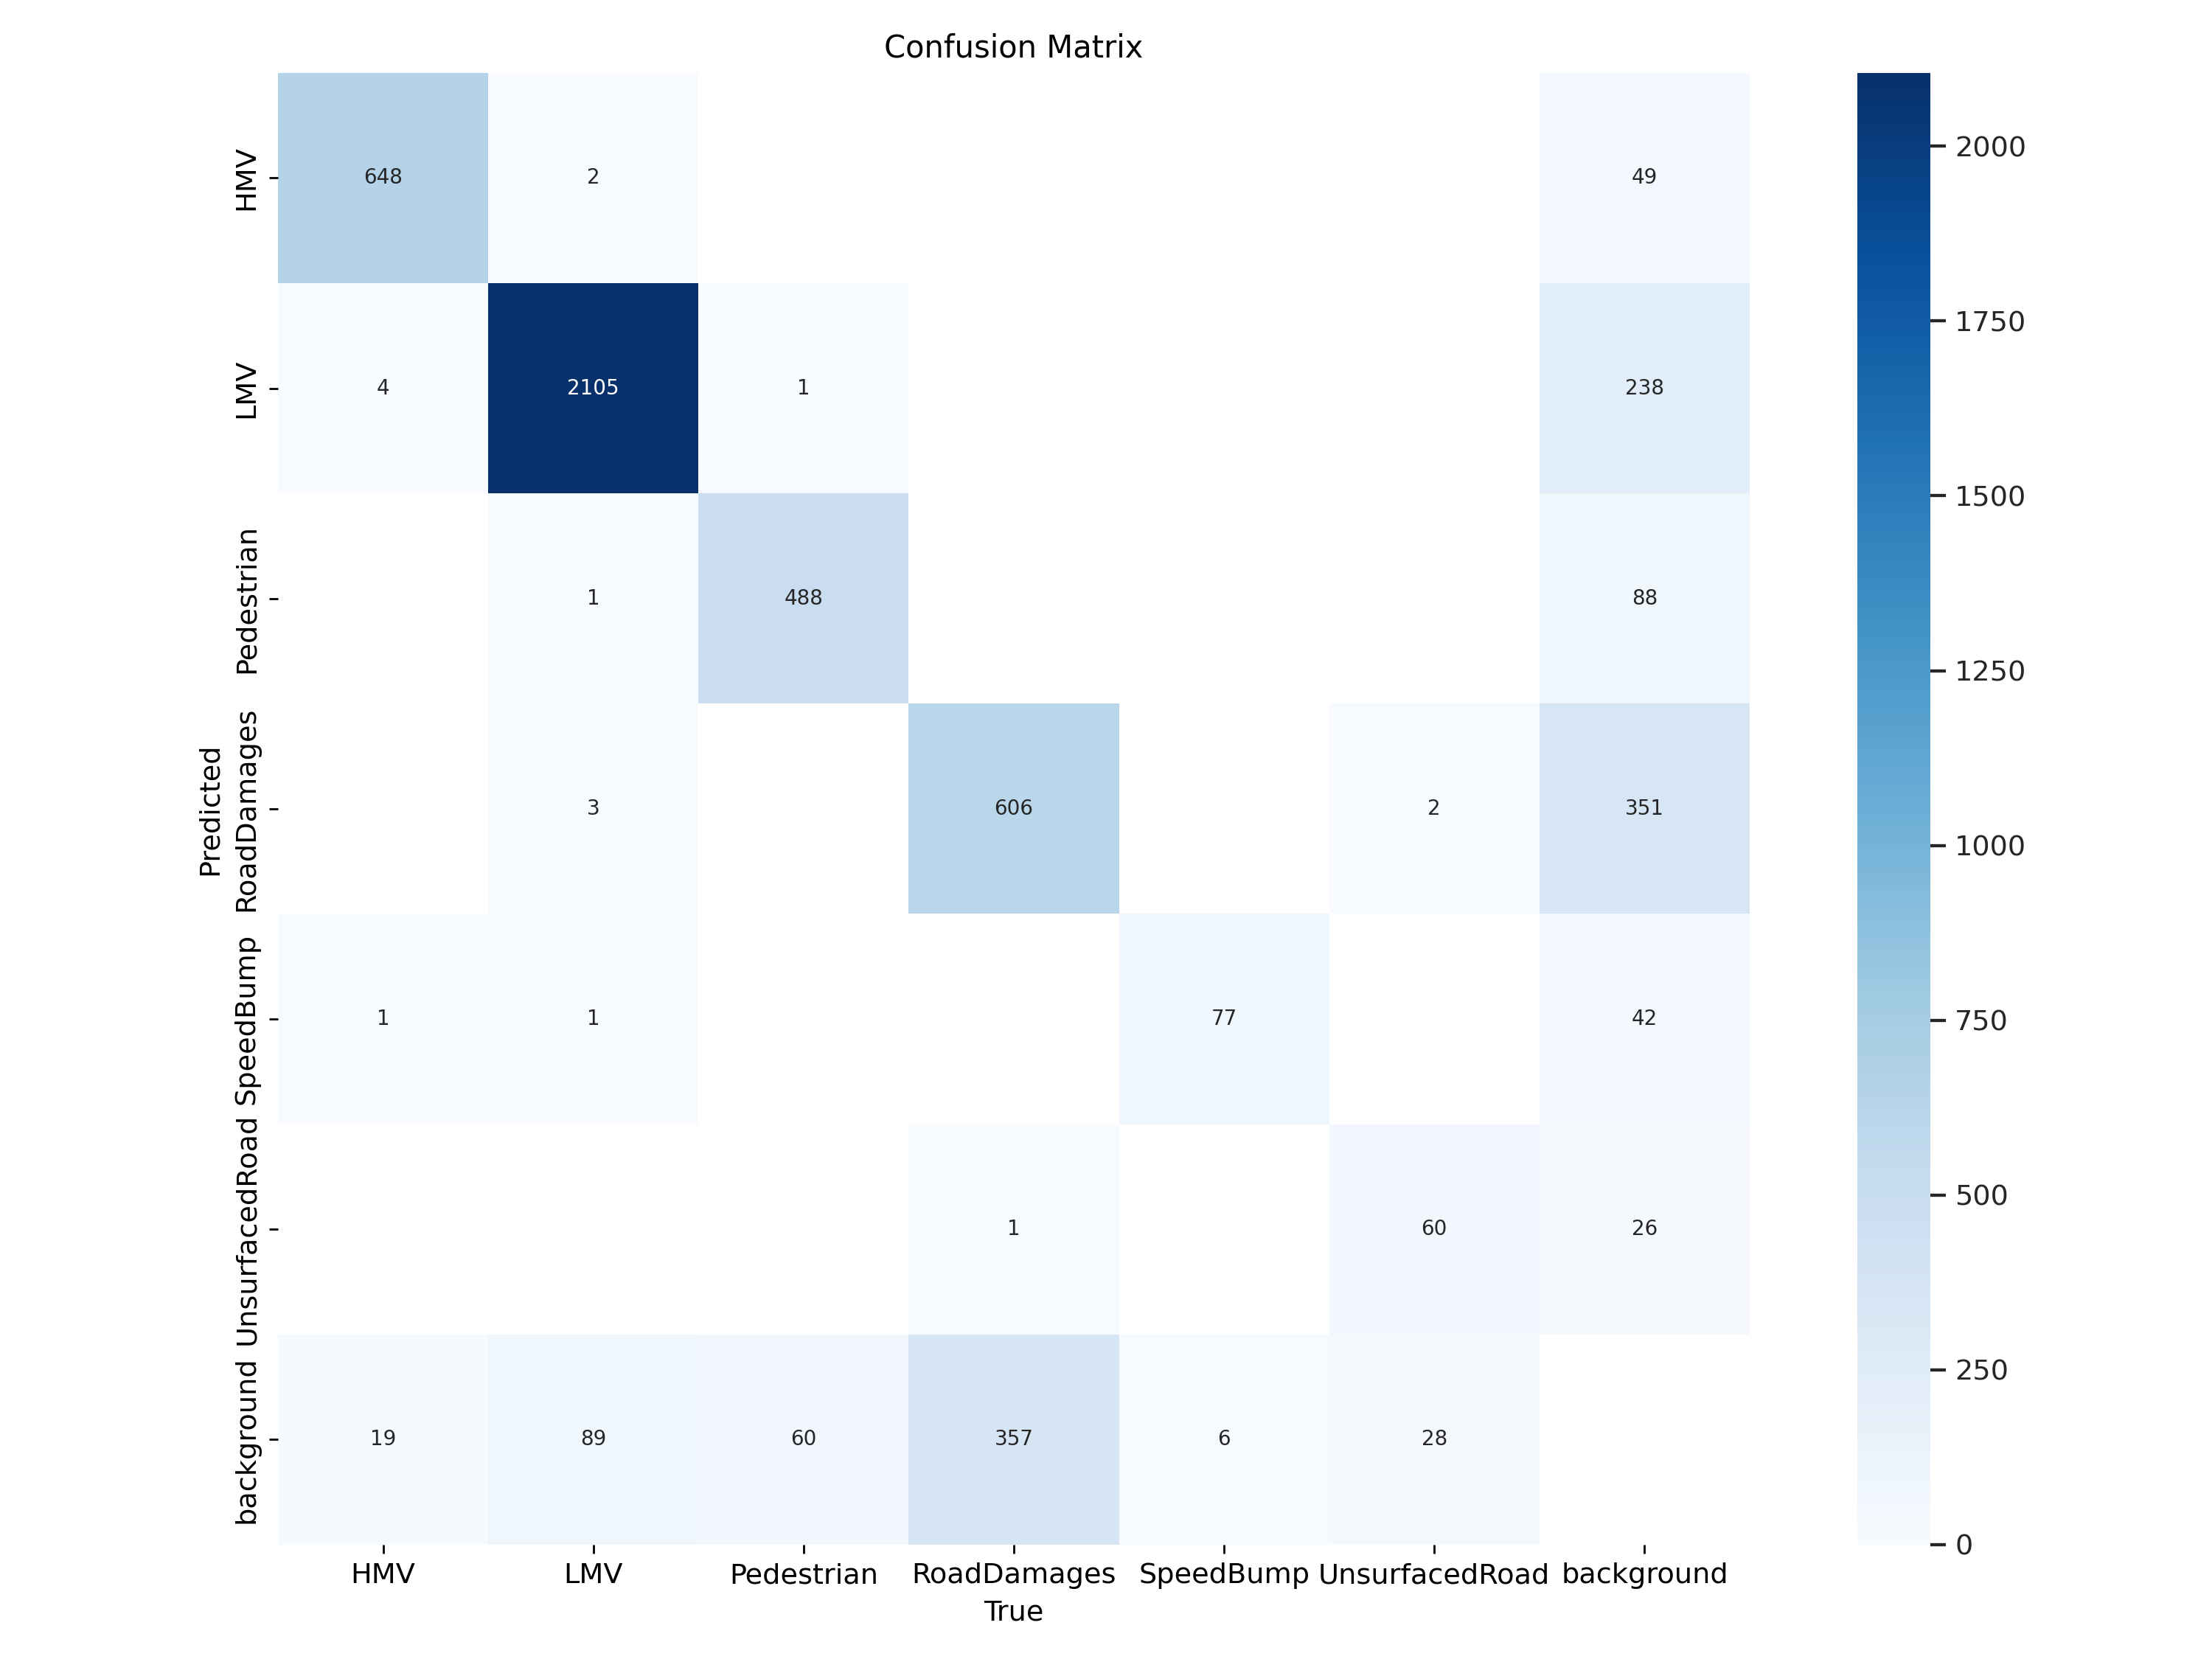

YOLOv8 - Confusion Matrix - Stage 2



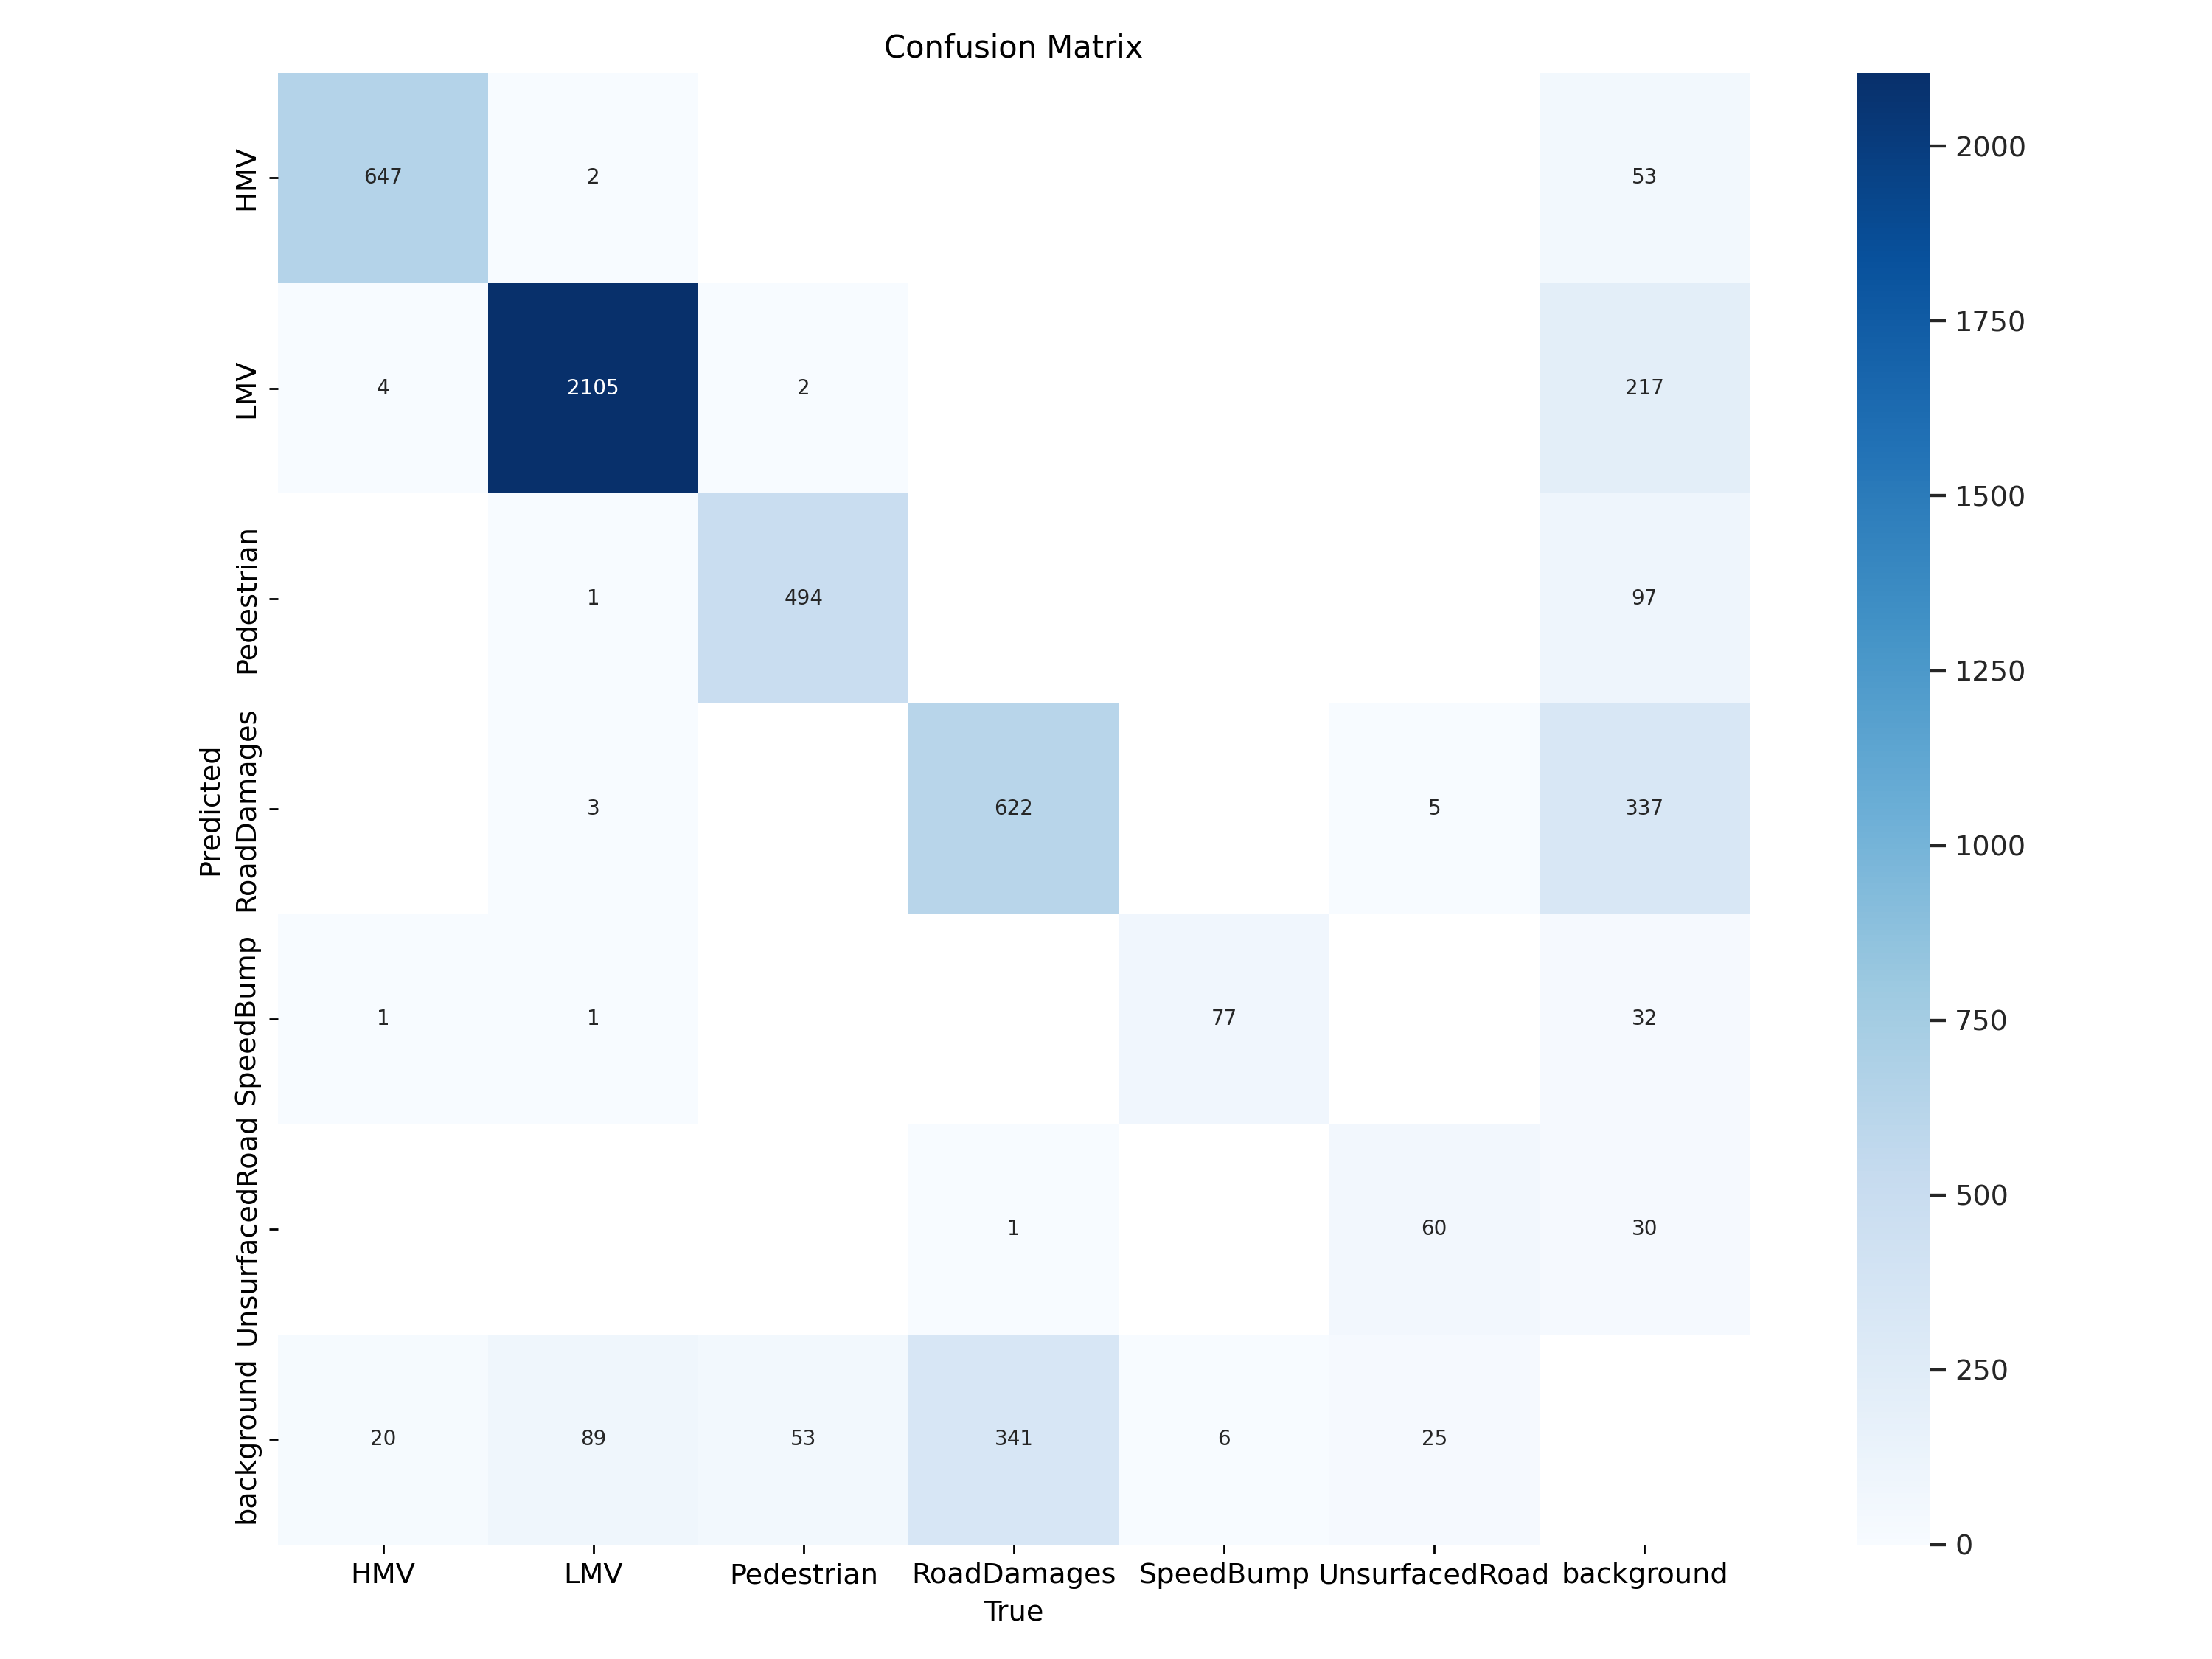

YOLOv8 - Confusion Matrix - Stage 3



In [9]:
for i in range(len(epochs_list)):
    run_name = f"{run_name_prefix_yolov8}_stage{i+1}"
    image_path = f"runs/detect/{run_name}/confusion_matrix.png"
    title = f"YOLOv8 - Confusion Matrix - Stage {i+1}"
    display_image(image_path, title)


Image not found: runs/detect/yolov8_stage1/val_batch0_pred.jpg


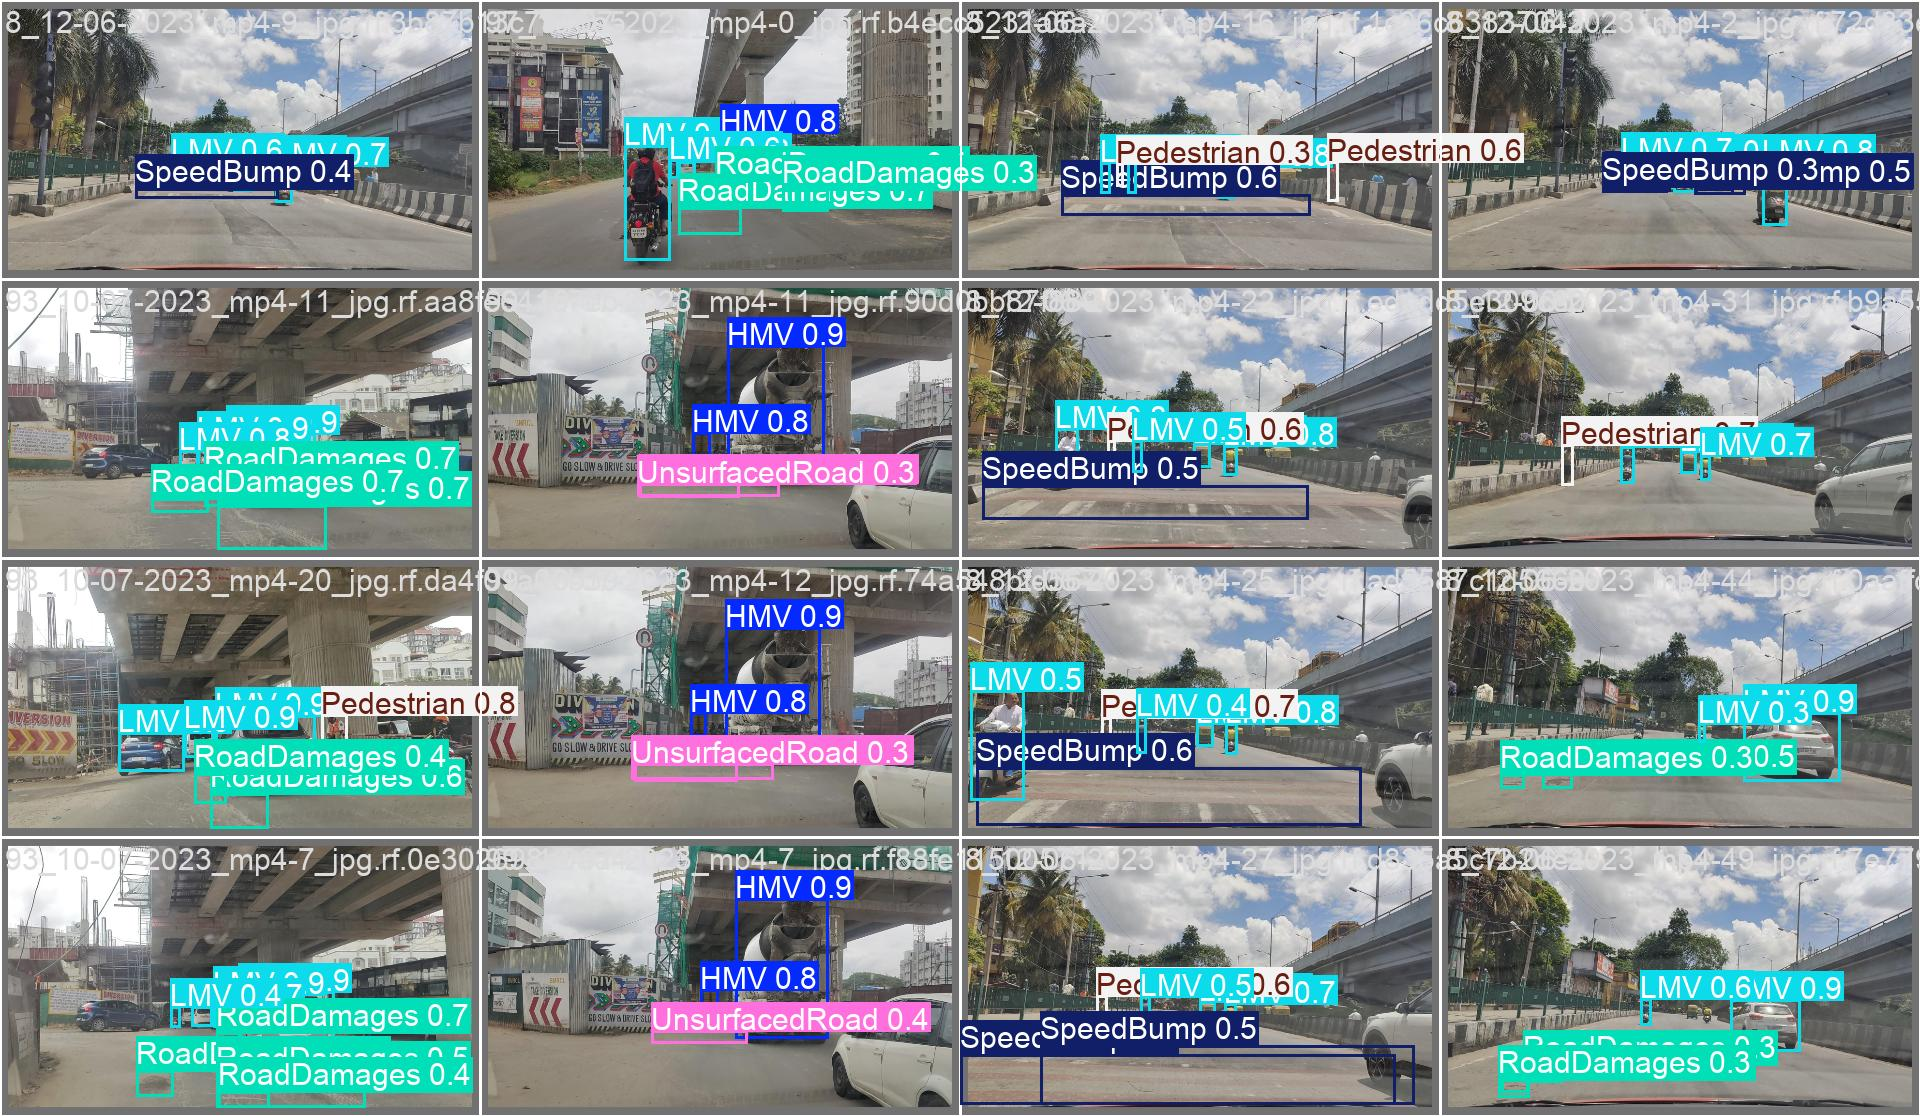

YOLOv8 - Validation Predictions - Stage 2



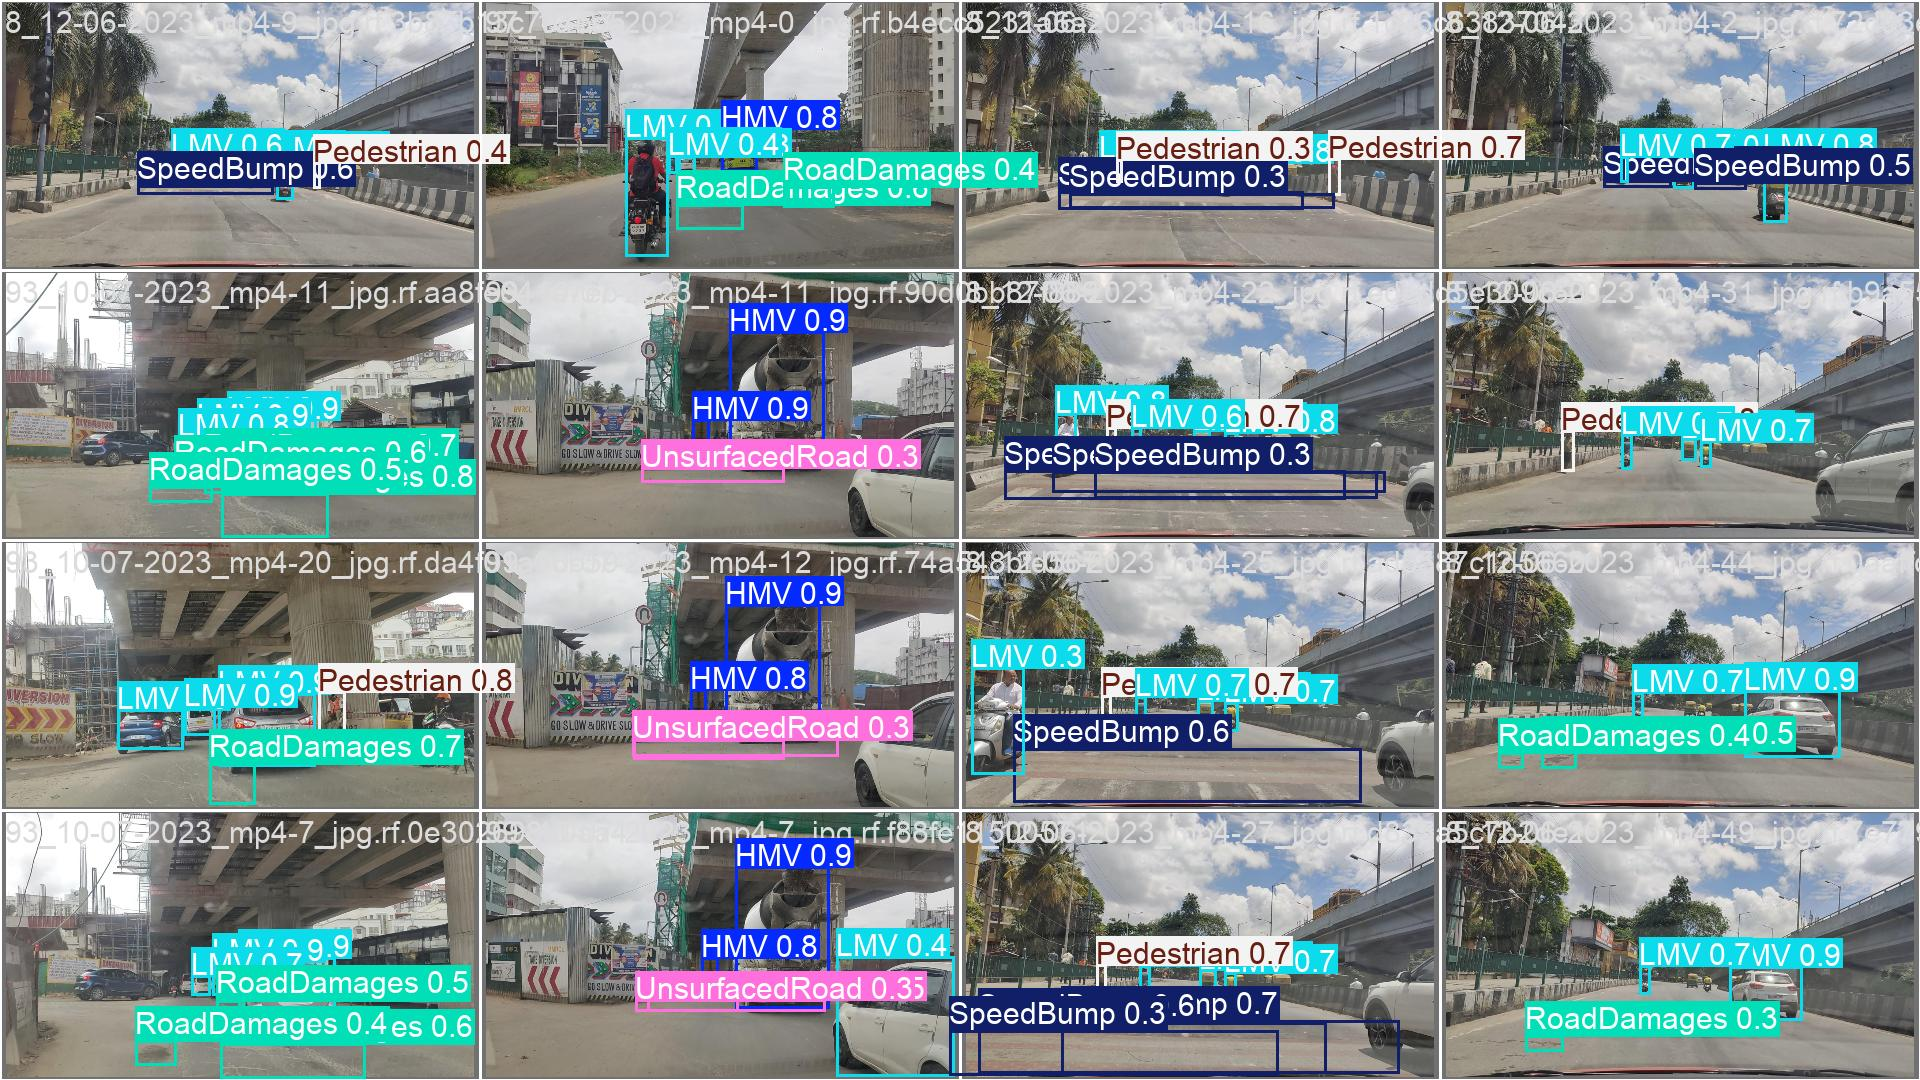

YOLOv8 - Validation Predictions - Stage 3



In [10]:
for i in range(len(epochs_list)):
    run_name = f"{run_name_prefix_yolov8}_stage{i+1}"
    image_path = f"runs/detect/{run_name}/val_batch0_pred.jpg"
    title = f"YOLOv8 - Validation Predictions - Stage {i+1}"
    display_image(image_path, title)

In [11]:
validate_yolov8(model_paths_yolov8, data_yaml_path)

Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 797, in entrypoint
    model = YOLO(model, task=task)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 145, in __init__
    self._load(model, task=task)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 285, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py", line 910, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py", line 837, in torch_safe_load
    ckpt = torch.load(fi

In [12]:
predict_yolov8(model_paths_yolov8, source_images)

Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 797, in entrypoint
    model = YOLO(model, task=task)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 145, in __init__
    self._load(model, task=task)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 285, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py", line 910, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py", line 837, in torch_safe_load
    ckpt = torch.load(fi

In [13]:

model_path_yolov8_video = model_paths_yolov8[1]  
output_path_yolov8 = '/kaggle/working/runs/detect/yolov8_output_video.mp4'

inference_video_yolov8(model_path_yolov8_video, video_path, output_path_yolov8)



0: 544x960 4 LMVs, 1 Pedestrian, 1 RoadDamages, 47.0ms
Speed: 4.1ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 4 LMVs, 1 Pedestrian, 1 RoadDamages, 7.3ms
Speed: 3.4ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 4 LMVs, 1 Pedestrian, 1 RoadDamages, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 4 LMVs, 1 Pedestrian, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 4 LMVs, 1 Pedestrian, 7.1ms
Speed: 3.2ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 4 LMVs, 1 Pedestrian, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 4 LMVs, 1 Pedestrian, 7.5ms
Speed: 3.4ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 960)

